## Crime Rhythm Maps

Exploring crime patterns with Ryhthm Maps, heat maps with two time dimensions. 


In [1]:
%matplotlib inline
# imports!
import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%run ../lib/crime.py

In [2]:
# Clarinova Place Codes, short names for San Diego places
cpc = rg.dataframe('gs://1tvXZKjyh5tdKHF2TUbQvW0hJoSjoG6dK4pA2SD-2pu4#1') #Google Spreadsheet
incidents = rg.dataframe('https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-5y.csv')

In [3]:
incidents['datetime'] = pd.to_datetime(incidents['date']+' '+incidents['time'])

In [4]:
# Merge in the community codes to get the community names
incidents = incidents[incidents.community!='NONE']\
            .merge(cpc[['name','code']], left_on='community', right_on='code', how='left')

A Rhythm map is a heat map with two time dimensions, which makes it much esier to find temporal patterns in some kinds of data. This example will use [crime incidents from San Diego county, from 2007 to 2013.](https://data.sandiegodata.org/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract). 

Plotting the number of incidents for burglary versus the hour of the day, for instance, results in this dull chart: 


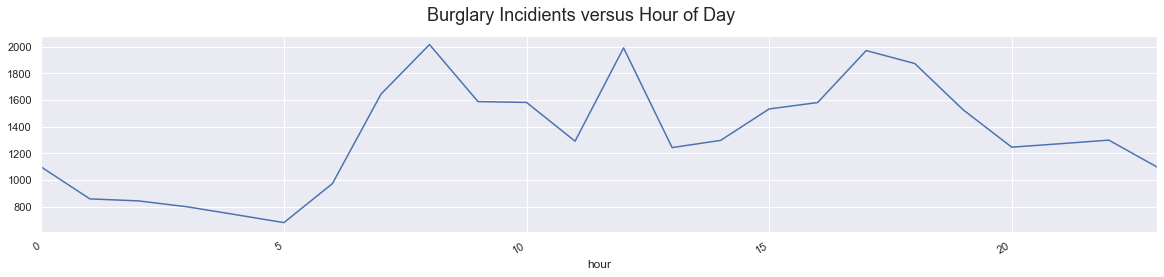

In [5]:
dfm= incidents.groupby(['hour','type'])
counts = dfm.count()
cus = counts.unstack(1)
uscounts = cus['id']
ax = uscounts['BURGLARY'].plot(subplots=True, figsize=(20,4))
plt.suptitle("Burglary Incidients versus Hour of Day", fontsize=18);

There are a few interesting patterns here, primarily the minimum at about 5:00AM. But nearly all categories of crime have a lull at 5:00 in the morning, which isn't very surprising. Part of the reason that the chart isn't very useful is that there are several types of burglarly, and they happen at different times of the week and different times of the day, a distinction which isn't visible in a line plot. So, let's look at burglary by hour of day and day of week.


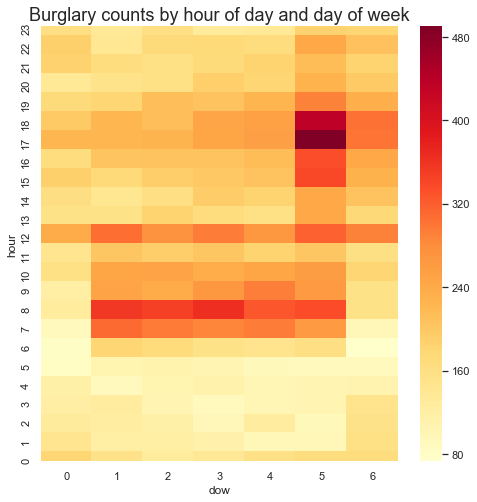

In [6]:
def proc_group(t):
    t = t.count()[['id']].unstack()
    t.columns = t.columns.droplevel()
    t = t.sort_index(ascending=False)
    return t

def plot_single_heatmap(t, title, ax=None):
    t = t.count()[['id']].unstack()
    t.columns = t.columns.droplevel()
    t = t.sort_index(ascending=False)
    sns.heatmap(t, cmap="YlOrRd", ax=ax).set_title(title, fontsize=18)

plt.figure(figsize=(8,8))
    
plot_single_heatmap(incidents[incidents.type == 'BURGLARY'].groupby(['hour','dow']),
                   'Burglary counts by hour of day and day of week')
    

Here we can see three patterns:
* A strong line at noon. This is an artifact of data collection; reports without a time probably default to noon. 
* A cluster in the mornings and afternoons of weekdays. These are residential burglaries. 
* A strong line in the early evening on Fridays; These are commercial burglaries. 

Here are the residential and commercial burglaries broken out. 


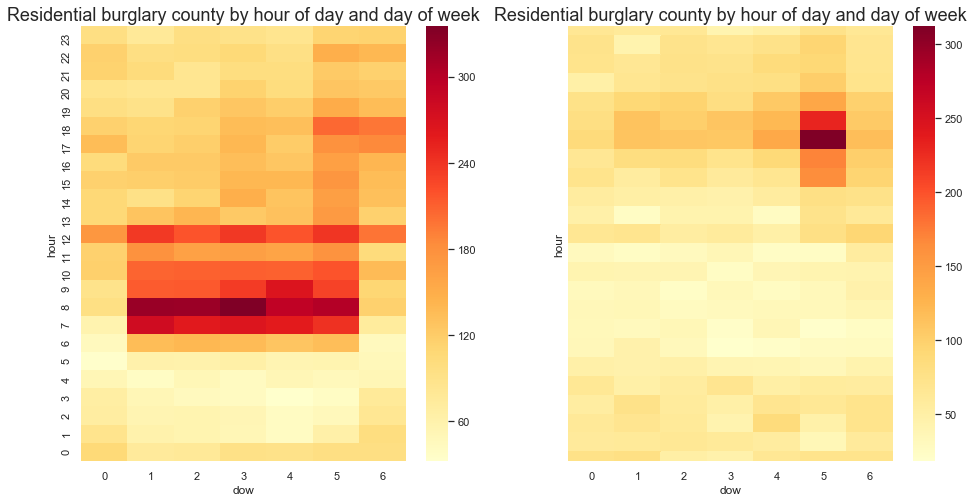

In [7]:

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))

plot_single_heatmap(incidents[incidents.desc=='RESIDENTIAL BURGLARY'].groupby(['hour','dow']),
                   "Residential burglary county by hour of day and day of week", ax=ax1);
    
plot_single_heatmap(incidents[incidents.desc=='COMMERCIAL BURGLARY'].groupby(['hour','dow']),
                   "Residential burglary county by hour of day and day of week", ax=ax2);
    
    

There are many different patterns like these for the different crime categories. 

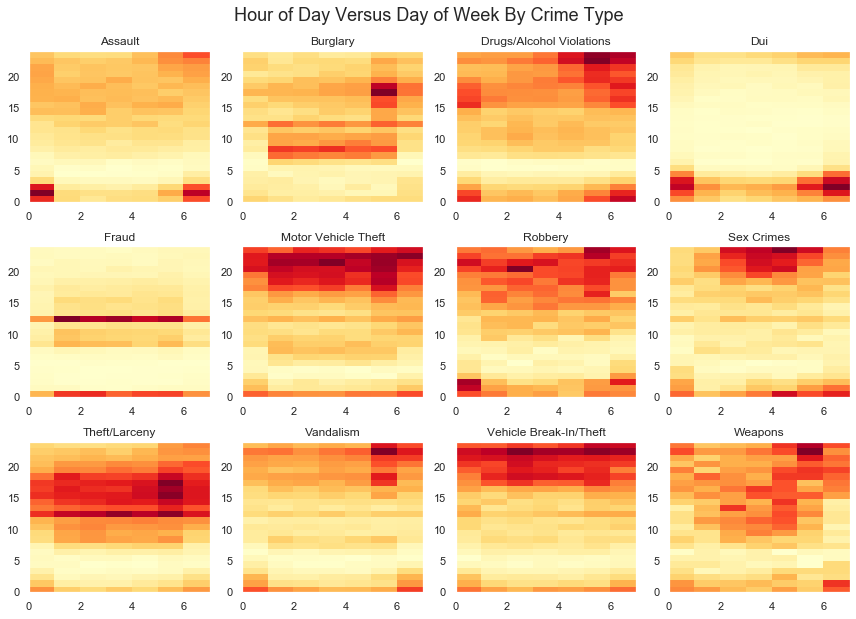

In [8]:

fig = plot_heat_grid(incidents, 'Hour of Day Versus Day of Week By Crime Type')


There are also different patterns for a single crime type for different communities. Alcohol violations in Downtown are very late on weekends, and much earlier on weekdays, while in Pacific Beach, the violations are more concentrated earlier on weekends, and UCSD students only get rowdy on Friday. 

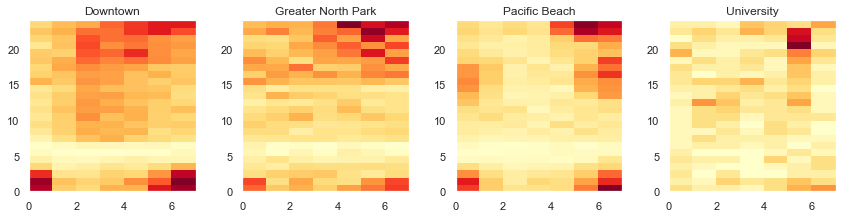

In [9]:

            
plot_heat_grid_community(incidents[incidents.type =='DRUGS/ALCOHOL VIOLATIONS'],
                         communities= ['SanDOW','SanGRE','SanPCF', 'SanUNV'])
            

Here is another interesting pattern in alcohol violations, when plotted by hour of day versus week of year: they are more common in the summers and more common after 3:00PM, except for week 27 -- the typical week of July 4 -- when the violations are spread through the entire day. 

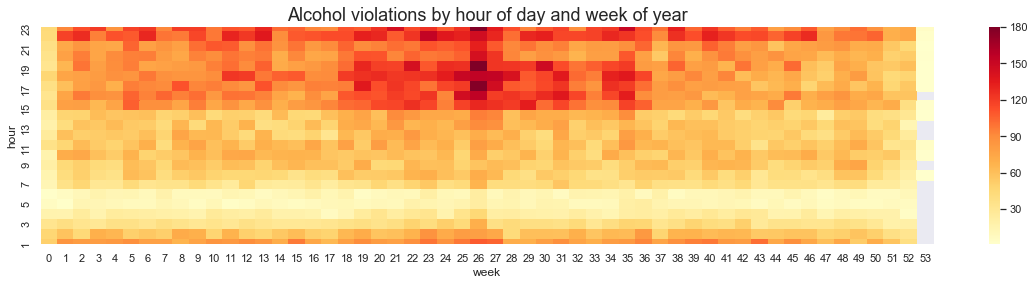

In [10]:
plt.figure(figsize=(20,4))
plot_single_heatmap(incidents[incidents.type == 'DRUGS/ALCOHOL VIOLATIONS'].groupby(['hour','week']),
                   'Alcohol violations by hour of day and week of year')
    

There are many other patterns to be found in crime dataset by looking at other combinations of time units, community, and crime type. If you'd like to explore some of these patterns, you can [clone, run and extend this notebook from github.](https://github.com/CivicKnowledge/insights.civicknowledge.com/blob/master/crime/Crime%20Rhythm%20Maps.ipynb)

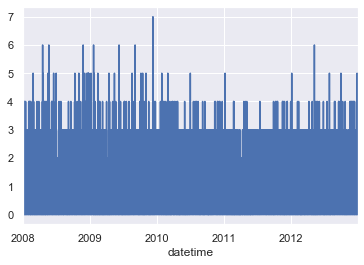

In [11]:

t = incidents[incidents.desc=='RESIDENTIAL BURGLARY'].copy()
t = t.set_index('datetime').groupby(pd.Grouper(freq='H')).count()['id']
t.plot()

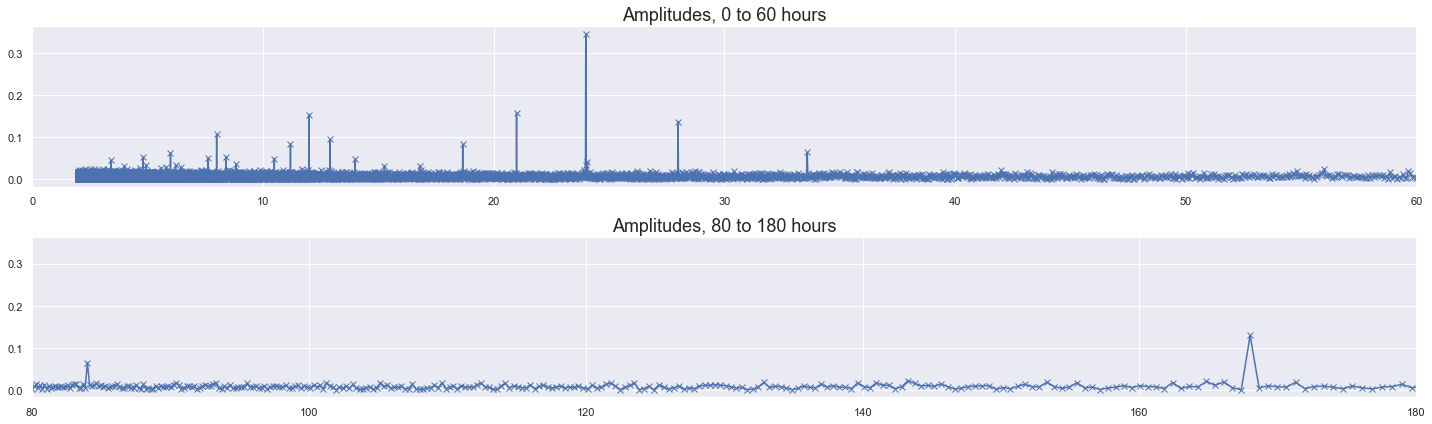

,freq,amp
period,,
23.998905,0.041669,0.346067
20.999042,0.047621,0.158237
11.999453,0.083337,0.153824
27.998723,0.035716,0.137281
167.992337,0.005953,0.129606
7.999635,0.125006,0.106893
12.922487,0.077384,0.095370
18.665815,0.053574,0.083372
11.199489,0.089290,0.082961


In [23]:

t = incidents[incidents.type=='ASSAULT'].copy()
y = t.set_index('datetime').groupby(pd.Grouper(freq='H')).count()['id']


x = y.reset_index().index.values


def fft(s, N=None, T=1):

    import scipy.fftpack
    
    if N is None:
        N = len(s)
    
    yf = scipy.fftpack.fft(s)[:N//2]
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    amp = 2.0/N * np.abs(yf)
    
    df =   pd.DataFrame({'freq':xf, 'amp':amp})
    df['period'] = df.freq.rtruediv(1.0).replace([np.inf, -np.inf], np.nan)
    
    return df

f = fft(y)

fig, ax = plt.subplots(2,1, figsize=(20, 6))
ax = ax.flat

ax[0].set_xlim(0,60)
ax[0].plot(f.period, f.amp, marker='x')
ax[0].set_title('Amplitudes, 0 to 60 hours', fontsize=18)
ax[1].set_xlim(80,180)
ax[1].plot(f.period, f.amp, marker='x' )
ax[1].set_title('Amplitudes, 80 to 180 hours', fontsize=18)


plt.tight_layout()
plt.show()

display(f[f.period<180].dropna().set_index('period').sort_values('amp',ascending=False).head(15))

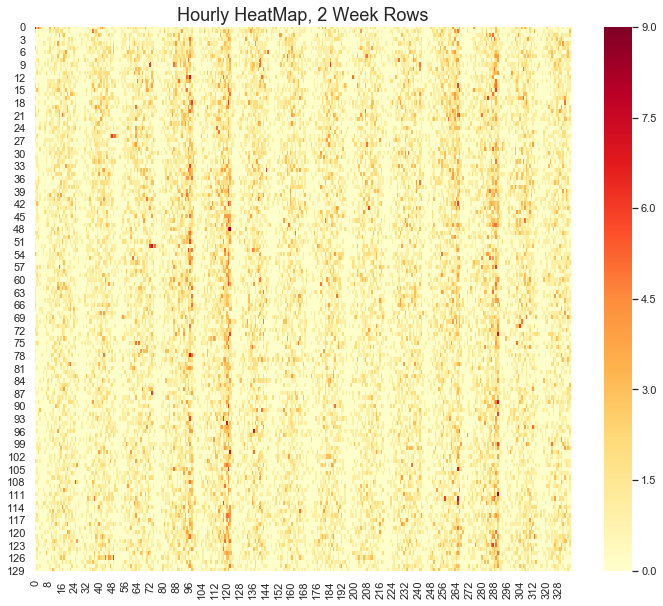

In [42]:
def pad_to_multiple(d, m):
    """Pad data d with zeros to have an even multiple of d"""
    l = np.ceil(len(d)/m)*n
    r = np.zeros(int(l))
    r[:len(d)] = d
    return r

def reshape_to_multiple(d, m):
    return pad_to_multiple(y.values, m).reshape((-1,m))

plt.figure(figsize=(12,10))
t = reshape_to_multiple(y.values, 2*168)
sns.heatmap(t, cmap="YlOrRd").set_title('Hourly HeatMap, 2 Week Rows', fontsize=18);